# Hypothesis Testing with Insurance Data (Core)- Amber Kutscher
- Data Enrichment


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Read in the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1. Do smokers have higher insurance charges than non-smokers?


- Null Hypothesis: There is no significant difference between the insurance charges of smokers and non-smokers.
- Alternative Hypothesis: There is a significant difference between the insurance charges of smokers and non-smokers.

In [22]:
# Create sample data for testing
sample = df.sample(n=50, random_state=42)
smoker_charges = sample.loc[sample['smoker'] == 'yes', "charges"]
non_smoker_charges = sample.loc[sample['smoker'] == 'no', "charges"]

print(f"For smokers (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"For non-smokers (n={len(non_smoker_charges)}): Mean={np.mean(non_smoker_charges):.2f}")

For smokers (n=11): Mean=35439.40
For non-smokers (n=39): Mean=7309.48


In [5]:
# Check for ourliers with smoker status
zscores_s = stats.zscore(smoker_charges)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

0

In [6]:
# Check for outliers with non-smoker status
zscores_ns = stats.zscore(non_smoker_charges)
outliers_ns = abs(zscores_ns)>3
np.sum(outliers_ns)

0

In [7]:
# Normal test smokers
result_s = stats.normaltest(smoker_charges)
result_s

C:\Users\amber\anaconda3\envs\dojo-env\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.209358578032982, pvalue=0.331317122245031)

In [8]:
# Normal test non-smokers
result_ns = stats.normaltest(non_smoker_charges)
result_ns

NormaltestResult(statistic=2.6262187199374125, pvalue=0.26898239167805005)

In [9]:
# Calculate overall results with levene
result = stats.levene(smoker_charges, non_smoker_charges)
result

LeveneResult(statistic=18.397400827816167, pvalue=8.621214599569032e-05)

In [10]:
# Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(smoker_charges, non_smoker_charges)
result

Ttest_indResult(statistic=13.237119558105961, pvalue=1.2286151200596125e-17)

In [11]:
# Is our result significant?
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000000000
Significant: True


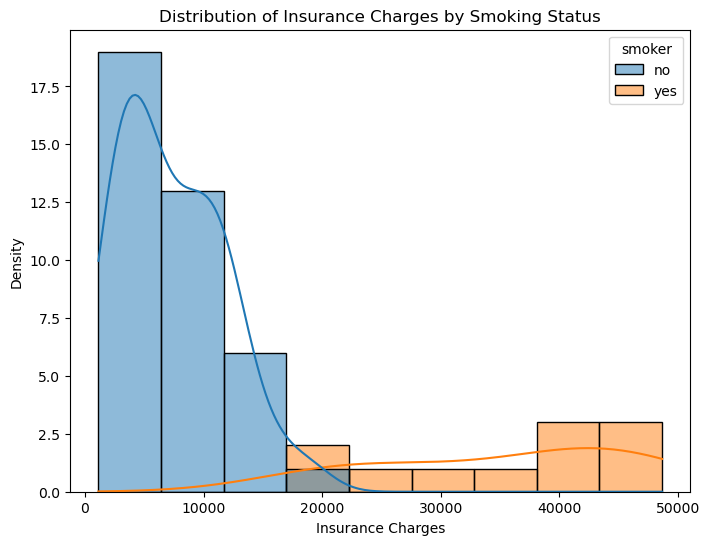

In [13]:
# Visualize the data
plt.figure(figsize=(8, 6))
sns.histplot(data=sample, x='charges', hue='smoker', kde=True)
plt.xlabel('Insurance Charges')
plt.ylabel('Density')
plt.title('Distribution of Insurance Charges by Smoking Status')
plt.show()

### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is less than 0.05, I reject the null hypothesis. This indicates that there is a significant difference between insurance charges of smokers vs. non-smokers.


## Q2. Are men more likely to smoke than women?


- Null Hypothesis: There is no significant difference showing that men are more likely to smoke than women.
- Alternative Hypothesis: There is a significant difference showing that men are more likely to smoke than women.

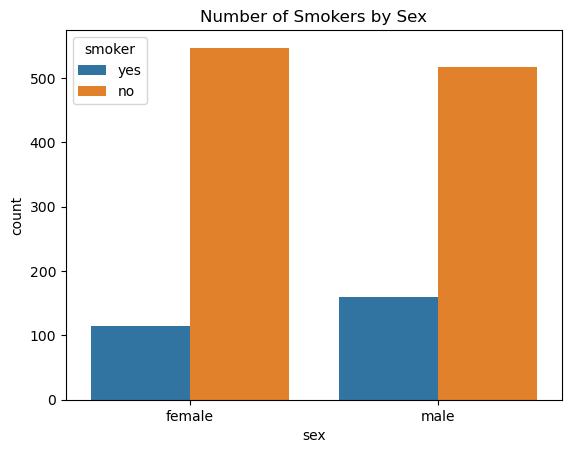

In [16]:
# Start by visualizing the data
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title("Number of Smokers by Sex");

In [17]:
# Calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [21]:
# Using Chi-Square test, run the test and save the output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [20]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is less than 0.05, I reject the null hypothesis. This indicates that men are more likely to smoke than women.

## Q3. Do different regions have different charges, on average?



- Null Hypothesis: There is no significant difference showing that the region affects how much someone pays for insurance.
- Alternative Hypothesis: There is a significant difference showing that the region affects how much someone pays for insurance.

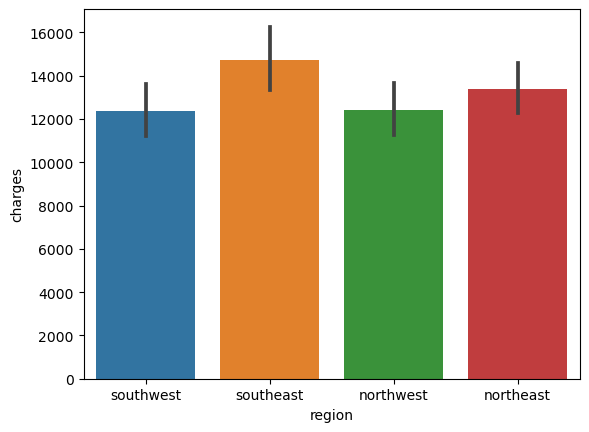

In [23]:
# Start by visualizing the data
sns.barplot(data=df, x='region', y='charges');

In [24]:
# Create groups dictionary
groups = {}
# Loop through all unique categories
for i in df['region'].unique():
    # Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    # Save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [25]:
# Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    # Save the p-val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [26]:
# Checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Save the values as charges and the labels to the region
values = df['charges']
labels = df['region']

In [28]:
# Perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is less than 0.05, I reject the null hypothesis. This indicates that there is a significant difference in average charges by region.